# Setup

## Set the fineness of the grids used in the calculations

The variable `patience` determines how long the calculations will take to run

* 0 - Coarse, and quick, results dubious but it runs fast (seconds)
* 1 - Results meaningful, but small number of points on graphs. (~10 min)
* 2 - Fine grids for pretty graphs. (~1 hour)


In [1]:
patience  = 0

## Import the required libraries


In [2]:
import sympy as sym
sym.init_printing()
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct, Dagger
from sympy.printing import print_ccode

import numpy as np

import math
from math import pi

from scipy import integrate, signal
import scipy.optimize
import scipy.constants as const
import scipy.io as sio

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize as Norm

import qutip

import time

%load_ext cython

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


## Some functions to help us make Liovillian superoperators
- Here we use an approach very similar to [qutip](https://qutip.org) and the [qotoolbox](https://qo.phy.auckland.ac.nz/toolbox/), reading the documention for those two packages might help make sense of spre, spost, etc
- This notebook uses Fortran order (column first) when flattening matricies

In [3]:
def spre(m):
    return TensorProduct(sym.eye(m.shape[0]), m)


def spost(m):
    return TensorProduct(m.T, sym.eye(m.shape[0]))


def collapse(c):
    temp = Dagger(c)*c/2
    return spre(c)*spost(Dagger(c)) - spre(temp) - spost(temp)

## Define atomic operators 
For example s13 is $|1\rangle\langle3|$ 

In [4]:
s13 = Matrix([[0, 0, 1], [0, 0, 0], [0, 0, 0]])
s23 = Matrix([[0, 0, 0], [0, 0, 1], [0, 0, 0]])
s12 = Matrix([[0, 1, 0], [0, 0, 0], [0, 0, 0]])

s31 = s13.T
s32 = s23.T
s21 = s12.T

s11 = s12*s21
s22 = s21*s12
s33 = s31*s13

## The symbolic variables we will use
- $\delta_2, \delta_3$ --  the detunings of the second and third atomic level respectively
- $\gamma_{13}, \gamma_{23}$ -- respectively the spontaneous emission rates from the excited state down the ground state and down to the second atomic level.
- $\gamma_{2d}, \gamma_{3d}$ -- the dephasing rates for the second atomic level and the optical excited state.
- $n_b$ -- the number of thermal photons in the bath coupled to the microwave transition
- $\gamma_\mu$ -- coupling rate between the $|1\rangle \rightarrow |2\rangle$ transition and this bath.
- $\Omega_o$ -- rabi frequency for the optical pump (drives the $|2\rangle \rightarrow |3\rangle$ transition) taken to be real
- $\Omega_\mu$ -- rabi frequency for the microwave input (drives the $|1\rangle \rightarrow |2\rangle$ transition)
- $\rho_{xy}$ -- components of the atomic density matrix
- $a$ -- cavity mode amplitude (scale is chosen like it's the operator $a$ even though we only treat it classically)
- $a_r, a_i$ -- real and imaginary parts of $a$
- $g$ -- coupling rate of a single atom between the  $|1\rangle \rightarrow |3\rangle$ transition and the output optical cavity mode.

In [5]:
delta2, delta3 = sym.symbols('delta_2 delta_3', real=True)

(gamma13, gamma23, gamma2d,
 gamma3d, nbath, gammamu) = sym.symbols(
    'gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_mu',
    real=True, negative=False)

omegao = sym.symbols('Omega_o', real=True, negative=False)
omegam = sym.symbols('Omega_mu', real=True, negative=False)
# omegamr, omegami = sym.symbols('Omega_mu_r Omega_mu_i',
#                                                real = True)

(rho11, rho12, rho13, rho21, rho22,
 rho23, rho31, rho32, rho33) = sym.symbols(
    'rho_11 rho_12 rho_13 rho_21 rho_22 rho_23 rho_31 rho_32 rho_33')

a = sym.symbols('a')
ar, ai = sym.symbols('a_r a_i', real=True)

g = sym.symbols('g', real=True, negative=False)

# Constructing the Liovillian analytically

In [6]:
# Make the Hamiltonian
H = omegam*s21 + omegao*s32 + g*a*s31
H = H + Dagger(H)
H = H + delta2*s22 + delta3*s33

# Make the Liovillian
LH = -I*spre(H)+I*spost(H)
L21 = gammamu*(nbath+1)*collapse(s12)
L12 = gammamu*(nbath)*collapse(s21)
L32 = gamma23*collapse(s23)
L31 = gamma13*collapse(s13)
L22 = gamma2d*collapse(s22)
L33 = gamma3d*collapse(s33)

L = LH + L21 + L12 + L32 + L31 + L22 + L33

# Rather than use the actual Liovillian we will use a modified Liovillian
# with the first row replaced a collections of ones and zeros that calculates
# what the trace of the density matrix would have been before it was flattened

L = L.row_insert(0, Matrix([[1, 0, 0, 0, 1, 0, 0, 0, 1]]))
L.row_del(1)

# The modified Liovillian is a  matrix that can be inverted
# The condition for the steady state is now L*rho=V
# where V = [1,0,0, 0,0,0, 0,0,0].T

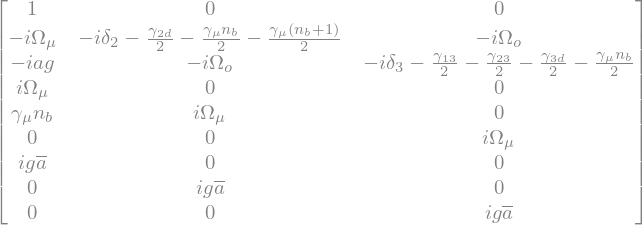

In [7]:
# The Liovillian is presented in chunks because it is
# too wide to show together when exporting this notebook to PDF
L[:, 0:3]

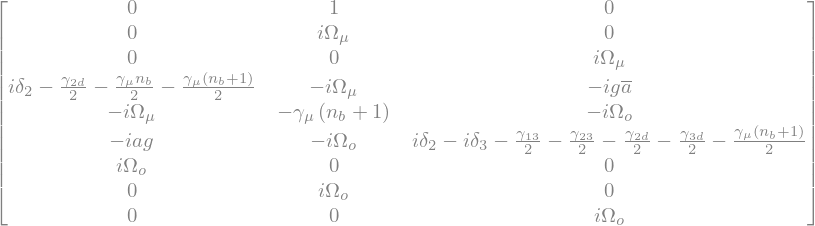

In [8]:
L[:, 3:6]

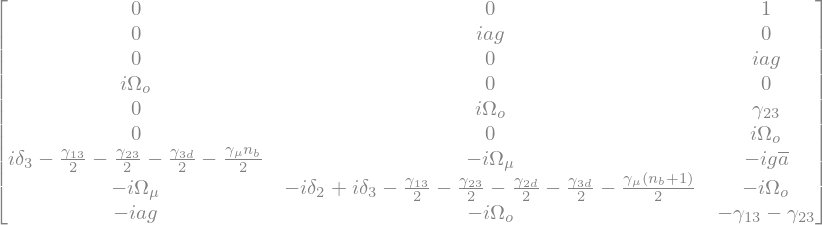

In [9]:
L[:, 6:9]

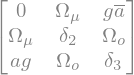

In [10]:
H

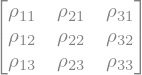

In [11]:
rho = Matrix([[rho11, rho21, rho31],
              [rho12, rho22, rho32],
              [rho13, rho23, rho33]])
rho

In [12]:
# rho flattened out to a vector
rho = 1*rho.T  # because we are using "fortran" style matrix flatteneing
rho[:]
rhoflat = 1*rho.T
rhoflat = rhoflat[:]
rhoflat

## Change of basis
We now transform the "basis" we use for our flattened density matrix so that all the elements are real. This means that we are solving a 9x9 system with real varaiables rather than a 9x9 system with complex variables and redundancy.


In [13]:
CtoR = Matrix([[2, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 2, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 2],
               [0, 1, 0, 1, 0, 0, 0, 0, 0],
               [0, I, 0, -I, 0, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0, 1, 0, 0],
               [0, 0, I, 0, 0, 0, -I, 0, 0],
               [0, 0, 0, 0, 0, 1, 0, 1, 0],
               [0, 0, 0, 0, 0, I, 0, -I, 0]
               ])/2

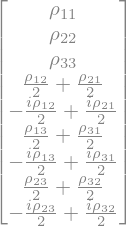

In [14]:
# This is our new vector to describe the atom density matrix
t = CtoR*Matrix(rhoflat)
t

In [15]:
# Our modified Liovillian in this new basis
Lreal = sym.simplify(CtoR*L*CtoR.inv())
Lreal = Lreal.subs(a, ar+I*ai)


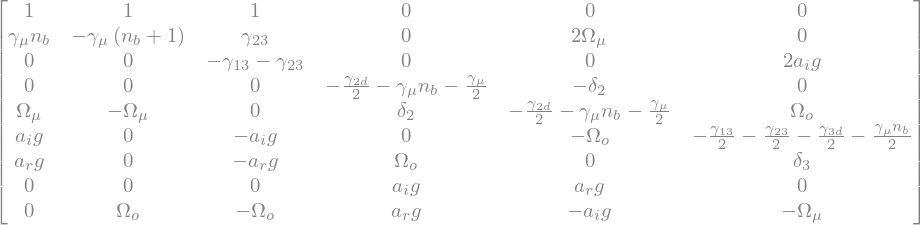

In [16]:
# The Lreal matrix in chuncks because it gets truncated exporting to pdf
Lreal[:, 0:6]

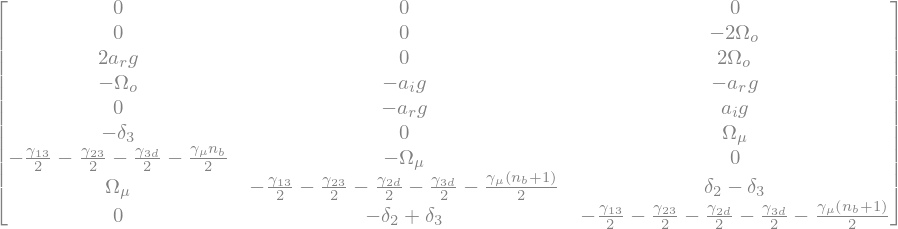

In [17]:
Lreal[:, 6:9]

## C-code from our analytic expressions

The output of this is copied an pasted into some of the functions that follow. Because it is destined for cython it's in row-major order

In [18]:
output = 'truncated'    # truncate output
# output = 'full'       # uncomment this line for full output

Lflatreal = 1*Lreal.T
Lflatreal = Lflatreal[:]

for k in range(81):
    if k < 10 or output == 'full':
        print("L[%d] = " % (k,), end="")
        print_ccode(Lflatreal[k])

if output == 'truncated':
    print('...')

L[0] = 1
L[1] = gamma_mu*n_b
L[2] = 0
L[3] = 0
L[4] = Omega_mu
L[5] = a_i*g
L[6] = a_r*g
L[7] = 0
L[8] = 0
L[9] = 1
...


# Numerical code for calulating steady state density matrix

## Python versions

This code uses the analytic expressions above to generate the modified Liovillian and then numerically solves the corrseponding system of equations to find the steady state density. This code is much slower than the cython versions below, but useful for confirming the correctness of the cython versions.



In [19]:
Lfunc = sym.lambdify((a, delta2, delta3, gamma13,
                      gamma23, gamma2d, gamma3d,
                      nbath, gammamu, omegao, omegam, g), L)

Lrealfunc = sym.lambdify((ar, ai, delta2, delta3,
                          gamma13, gamma23, gamma2d,
                          gamma3d, nbath, gammamu,
                          omegao, omegam, g), Lreal)

# This function finds the steady state density matrix
# the input p is a python dictionary full of parameters.


def steady_rho_python(p):
    Lmatrix = Lfunc(p['a'], p['delta2'], p['delta3'],
                    p['gamma13'], p['gamma23'], p['gamma2d'], 
                    p['gamma3d'], p['nbath'], p['gammamu'],
                    p['omegao'], p['omegam'], p['g'])
    rho = np.linalg.solve(Lmatrix.astype('complex128'),
                          np.matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0]]).T)
    return np.reshape(rho, (3, 3), order='F')

## Cython versions

Implemented in cython to (greatly) increase speed.

In [20]:
%%cython 
##%%cython --compile-args=-fopenmp --link-args=-fopenmp --verbose --force
# %%cython -a # this gives "highligted" output
# cython: boundscheck=False, wraparound=False, nonecheck=False

cimport cython
import numpy as np
from cython.parallel cimport prange
cimport scipy.linalg.cython_lapack as lapack
import numpy as np
from libc.math cimport exp


# This function accepts a python dictionary of parameters (p) and returns
# the steady state value of the the rho_13 density matrix element.

cdef double return2(double x):
    cdef double y = 2.
    return y


cdef double complex steady_rho13_lots_of_args(double a_r,
                                              double a_i,
                                              double delta_2,
                                              double delta_3,
                                              double gamma_13,
                                              double gamma_23,
                                              double gamma_2d,
                                              double gamma_3d,
                                              double n_b,
                                              double gamma_mu,
                                              double Omega_o,
                                              double Omega_mu,
                                              double g) nogil:
    cdef double L[81]
    cdef double V[9]
    cdef int n = 9
    cdef double complex a
    cdef int info
    cdef int lda = 9
    cdef int ldb = 9
    cdef int nrhs = 1
    cdef int workspace[9]
    cdef int k

    # Unfortunately we cant use this syntax if we dont have the GIL
    #V[:] = [1,0,0, 0,0,0, 0,0,0]
    #L[:] = (1, gamma_mu*n_b, 0, 0, ...

    for k in range(9):
        V[k] = 0
    V[0] = 1

    L[0] = 1
    L[1] = gamma_mu*n_b
    L[2] = 0
    L[3] = 0
    L[4] = Omega_mu
    L[5] = a_i*g
    L[6] = a_r*g
    L[7] = 0
    L[8] = 0
    L[9] = 1
    L[10] = -gamma_mu*(n_b + 1)
    L[11] = 0
    L[12] = 0
    L[13] = -Omega_mu
    L[14] = 0
    L[15] = 0
    L[16] = 0
    L[17] = Omega_o
    L[18] = 1
    L[19] = gamma_23
    L[20] = -gamma_13 - gamma_23
    L[21] = 0
    L[22] = 0
    L[23] = -a_i*g
    L[24] = -a_r*g
    L[25] = 0
    L[26] = -Omega_o
    L[27] = 0
    L[28] = 0
    L[29] = 0
    L[30] = -1.0/2.0*gamma_2d - gamma_mu*n_b - 1.0/2.0*gamma_mu
    L[31] = delta_2
    L[32] = 0
    L[33] = Omega_o
    L[34] = a_i*g
    L[35] = a_r*g
    L[36] = 0
    L[37] = 2*Omega_mu
    L[38] = 0
    L[39] = -delta_2
    L[40] = -1.0/2.0*gamma_2d - gamma_mu*n_b - 1.0/2.0*gamma_mu
    L[41] = -Omega_o
    L[42] = 0
    L[43] = a_r*g
    L[44] = -a_i*g
    L[45] = 0
    L[46] = 0
    L[47] = 2*a_i*g
    L[48] = 0
    L[49] = Omega_o
    L[50] = -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - \
        1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b
    L[51] = delta_3
    L[52] = 0
    L[53] = -Omega_mu
    L[54] = 0
    L[55] = 0
    L[56] = 2*a_r*g
    L[57] = -Omega_o
    L[58] = 0
    L[59] = -delta_3
    L[60] = -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - \
        1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b
    L[61] = Omega_mu
    L[62] = 0
    L[63] = 0
    L[64] = 0
    L[65] = 0
    L[66] = -a_i*g
    L[67] = -a_r*g
    L[68] = 0
    L[69] = -Omega_mu
    L[70] = -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0 * \
        gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1)
    L[71] = -delta_2 + delta_3
    L[72] = 0
    L[73] = -2*Omega_o
    L[74] = 2*Omega_o
    L[75] = -a_r*g
    L[76] = a_i*g
    L[77] = Omega_mu
    L[78] = 0
    L[79] = delta_2 - delta_3
    L[80] = -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0 * \
        gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1)
    lapack.dgesv( & n, & nrhs, L, & lda, workspace, V, & ldb, & info)
    return V[5]+1j*V[6]


# Steady state an ensemble of atoms, returns a matrix of rho13 values as 
# well as the list of weights from the inhomogeneous broadening distribution.
# Convolve the two to get simulate single pass Raman heterodyne signal 
# as a function of frequency for the optically thin case.

def ensemble_steady_rho13(p, delta2vals, delta3vals):
    cdef double a_r, a_i, delta_2, delta_3, gamma_13,
    cdef double gamma_23, gamma_2d, gamma_3d, n_b,
    cdef double gamma_mu, Omega_o, Omega_mu, g
    a = p['a']
    a_r = a.real
    a_i = a.imag
    delta_2 = p['delta2']
    delta_3 = p['delta3']
    gamma_13 = p['gamma13']
    gamma_23 = p['gamma23']
    gamma_2d = p['gamma2d']
    gamma_3d = p['gamma3d']
    n_b = p['nbath']
    gamma_mu = p['gammamu']
    Omega_o = p['omegao']
    Omega_mu = p['omegam']
    g = p['g']

    cdef int ii
    cdef int jj

    cdef double m2 = p['mean_delta2']
    cdef double sd2 = p['sd_delta2']
    cdef double m3 = p['mean_delta3']
    cdef double sd3 = p['sd_delta3']
    # print(sd3)

    cdef double[:] delta2valsv = delta2vals
    cdef double[:] delta3valsv = delta3vals

    cdef int ndelta2 = len(delta2vals)
    cdef int ndelta3 = len(delta3vals)

    cdef double df2 = delta2valsv[1]-delta2valsv[0]
    cdef double df3 = delta3valsv[1]-delta3valsv[0]

    # make numpy array
    coh13 = np.zeros((ndelta2, ndelta3), dtype='complex128')
    # make cython  "view" of the data
    cdef double complex[:, :] coh13v = coh13 

    # make numpy array for gaussian weights
    w = np.zeros((ndelta2, ndelta3), dtype='complex128')
    # make cython  "view" of the data
    cdef double complex[:, :] wv = w 

    for ii in prange(ndelta2, nogil=True):
        # for ii in range(ndelta2):
        delta_2 = delta2valsv[ii]
        for jj in range(ndelta3):
            delta_3 = delta3valsv[jj]
            coh13v[ii, jj] = steady_rho13_lots_of_args(a_r,
                                                       a_i,
                                                       delta_2,
                                                       delta_3,
                                                       gamma_13,
                                                       gamma_23,
                                                       gamma_2d,
                                                       gamma_3d,
                                                       n_b,
                                                       gamma_mu,
                                                       Omega_o,
                                                       Omega_mu,
                                                       g)
            wv[ii, jj] = 1.0/(2*3.14159265358979323846*sd3*sd2) * \
                exp(-(delta_2-m2)**2/(2*sd2*sd2)-(delta_3-m3)**2/(2*sd3*sd3))
    return (coh13, w)


# Steady state of an ensemble of atoms, returns a matrix of rho values as well 
# as the list of weights from the inhomogeneous broadening distribution.
# Convolve the two to simulate single pass raman heterodyne signal
# as a function of frequency

# p is a dictionary of parameters
# delta2vals and delta3vals are lists of numbers to use for the detunings

def ensemble_steady_rho(p, delta2vals, delta3vals):
    cdef double a_r, a_i, delta_2, delta_3, gamma_13, gamma_23,
    cdef double gamma_2d, gamma_3d, n_b, gamma_mu, Omega_o, Omega_mu, g
    a = p['a']
    a_r = a.real
    a_i = a.imag
    delta_2 = p['delta2']
    delta_3 = p['delta3']
    gamma_13 = p['gamma13']
    gamma_23 = p['gamma23']
    gamma_2d = p['gamma2d']
    gamma_3d = p['gamma3d']
    n_b = p['nbath']
    gamma_mu = p['gammamu']
    Omega_o = p['omegao']
    Omega_mu = p['omegam']
    g = p['g']

    cdef int ii
    cdef int jj
    cdef int kk

    cdef double m2 = p['mean_delta2']
    cdef double sd2 = p['sd_delta2']
    cdef double m3 = p['mean_delta3']
    cdef double sd3 = p['sd_delta3']
    # print(sd3)

    cdef double[:] delta2valsv = delta2vals
    cdef double[:] delta3valsv = delta3vals

    cdef int ndelta2 = len(delta2vals)
    cdef int ndelta3 = len(delta3vals)

    cdef double df2 = delta2valsv[1]-delta2valsv[0]
    cdef double df3 = delta3valsv[1]-delta3valsv[0]

    rho = np.zeros((ndelta2, ndelta3, 9),
                   dtype='complex128')  # make numpy array
    # make cython  "view" of the data
    cdef double complex[:, :, :] rhov = rho

    tmp = np.zeros((9,), dtype='complex128')  # make numpy array
    # make cython  "view" for temporary array
    cdef double complex[:] tmpv = tmp

    # make numpy array for gaussian weights
    w = np.zeros((ndelta2, ndelta3), dtype='complex128')
    # make cython  "view" of the data
    cdef double complex[:, :] wv = w

    for ii in prange(ndelta2, nogil=True):
        # for ii in range(ndelta2):
        delta_2 = delta2valsv[ii]
        for jj in range(ndelta3):
            delta_3 = delta3valsv[jj]
            for kk in range(9):
                rhov[ii, jj, kk] = tmpv[kk]
            wv[ii, jj] = 1.0/(2*3.14159265358979323846*sd3*sd2) * \
                exp(-(delta_2-m2)**2/(2*sd2*sd2)-(delta_3-m3)**2/(2*sd3*sd3))
    return (rho, w)


# Integrate over an ensemble using Simpson's rule to find the
# net coherence of the ensemble of atoms

# p is a dictionary of parameters
# df is the frequency resolution used when 
# integrating over the inhomogeneous broadenings


cpdef ensemble_steady_rho13_integrated(p, double df):
    cdef double a_r, a_i, delta_2, delta_3, gamma_13, gamma_23
    cdef double gamma_2d, gamma_3d, n_b, gamma_mu, Omega_o, Omega_mu, g
    a = p['a']
    a_r = a.real
    a_i = a.imag
    delta_2 = p['delta2']
    delta_3 = p['delta3']
    gamma_13 = p['gamma13']
    gamma_23 = p['gamma23']
    gamma_2d = p['gamma2d']
    gamma_3d = p['gamma3d']
    n_b = p['nbath']
    gamma_mu = p['gammamu']
    Omega_o = p['omegao']
    Omega_mu = p['omegam']
    g = p['g']

    cdef int ii
    cdef int jj

    cdef double m2 = p['mean_delta2']
    cdef double sd2 = p['sd_delta2']
    cdef double m3 = p['mean_delta3']
    cdef double sd3 = p['sd_delta3']

    cdef int w2, w3

    cdef int ndelta2 = 2*int(3*sd2/df)+1
    cdef int ndelta3 = 2*int(3*sd3/df)+1
    # print(ndelta2,ndelta3)

    delta2vals = np.linspace(-3, 3, ndelta2)*sd2+m2
    delta3vals = np.linspace(-3, 3, ndelta3)*sd3+m3

    cdef double[:] delta2valsv = delta2vals
    cdef double[:] delta3valsv = delta3vals

    simpsonw2 = np.empty((ndelta2,), dtype='int32')
    cdef int[:] simpsonw2v = simpsonw2
    simpsonw3 = np.empty((ndelta3,), dtype='int32')
    cdef int[:] simpsonw3v = simpsonw3

    ii = 0
    while(ii < (ndelta2-1)):
        simpsonw2v[ii] = 2
        ii += 1
        simpsonw2v[ii] = 4
        ii += 1
    simpsonw2v[0] = 1
    simpsonw2v[ndelta2-1] = 1

    ii = 0
    while(ii < (ndelta3-1)):
        simpsonw3v[ii] = 2
        ii += 1
        simpsonw3v[ii] = 4
        ii += 1
    simpsonw3v[0] = 1
    simpsonw3v[ndelta3-1] = 1

    cdef double complex z = 0
    cdef double sum_r = 0
    cdef double sum_i = 0
    cdef double gaussie
    for ii in prange(ndelta2, nogil=True):
        # for ii in range(ndelta2):
        delta_2 = delta2valsv[ii]
        w2 = simpsonw2v[ii]
        for jj in range(ndelta3):
            delta_3 = delta3valsv[jj]
            w3 = simpsonw3v[jj]
            gaussie = 1.0/(2*3.14159265358979323846*sd3*sd2) * \
                exp(-(delta_2-m2)**2/(2*sd2*sd2)-(delta_3-m3)**2/(2*sd3*sd3))
            z = steady_rho13_lots_of_args(a_r,
                                          a_i,
                                          delta_2,
                                          delta_3,
                                          gamma_13,
                                          gamma_23,
                                          gamma_2d,
                                          gamma_3d,
                                          n_b,
                                          gamma_mu,
                                          Omega_o,
                                          Omega_mu,
                                          g)*gaussie*w2*w3
            # this is because cython doesn't know how to
            # automatically do reductions for
            # but does for doubles
            sum_r += z.real
            sum_i += z.imag
    return (sum_r+sum_i*1j)*df*df/9.0

# Cavity dynamics


The (classical) equations of motion of the cavity mode amplitude are given by 
$$
\frac{d}{dt} a = -i \delta_c a -i\sum_k g_k \sigma_{13,k} - \frac{(\kappa_i+\kappa_c)}{2}a - \sqrt{\kappa_c} a_{in}.
$$
Here $\kappa_i$ is the intrisic loss rate of our cavity and $\kappa_c$ is the coupling induced loss.

Defining 
$$
S_{13}(a)= \sum_k g_k \sigma_{13,k} .
$$ 
We write $S_{13}(a)$ to remind us (explicitly) that the atoms states are a functions of the cavity mode amplitude $a$.

Because we won't drive $a$ this becomes
$$
\frac{d}{dt} a = -i \delta_c a
-i S_{13}(a)
- \frac{(\kappa_i+\kappa_c)}{2}a.
$$
So to find the steady state of the cavity we need to find the roots of the function
$$
f(a) = -i \delta_c a
-i S_{13}(a)
- \frac{(\kappa_i+\kappa_c)}{2}a .
$$

In [21]:
# The function "f" above, parameters via the dictionary p
def ffunc(p):
    df = p['df']
    a = p['a']
    N = p['N']
    g = p['g']
    deltac = p['deltac']
    kappa = p['kappaoi']+p['kappaoc']
    S13 = N*g*ensemble_steady_rho13_integrated(p, df)
    return -1j*deltac*a - 1j*S13 - kappa/2*a

# The same function but in a form that maps a 2d vector
# to a 2d vector rather than complex -> complex.
# This enables us to use scipy root finding routines.


def ffunc_for_root(avec, p):
    a = avec[0] + 1j*avec[1]
    # print(a)
    p['a'] = a
    f = ffunc(p)
    return [f.real, f.imag]

# Finds the steady state cavity amplitude for given parameters p


def steadya(p):
    # use value of a in p as the initial guess
    a = p['a']
    avec = [a.real, a.imag]
    df = p['df']
    result = scipy.optimize.root(ffunc_for_root, avec, args=(p))
    if not result.success:
        print(result)
        raise(AssertionError(
            'Grrr - The root finder didn\'t converge: '+result.message))
    # update p['a'] why not?
    a = result.x[0] + 1j*result.x[1]
    p['a'] = a
    return a

# Modelling the experiment

## Somewhere to store the results

In [22]:
saved_output = {}

## Anciliary functions

This calculates microwave Rabi frequency from the power incident in dBm

In [23]:
def omegam_from_Pin(Pin, p):
    mu0 = 4*pi*1e-7
    hbar = 1.05457e-34  # in J*s

    # the volume of the Er:YSO sample
    Vsample = pi*((p['dsample']/2)**2) * p['Lsample']
    V_microwave_cavity = Vsample/p['fillfactor']

    mwP = 1e-3 * 10**(Pin/10)  # convert from dBm to Watts
    Q = 2*pi*p['freqm'] / (p['kappami'] + p['kappamc']*2)  # Q factor
    S21 = (4*p['kappamc']**2) / (p['kappami'] + p['kappamc']*2)**2

    # energy inside the microwave cavity, in J
    energy_in_cavity = math.sqrt(S21)*2 / (2*pi*p['freqm']/Q)*mwP

    # Magnetic field of the microwave
    Bmw = math.sqrt(mu0*(energy_in_cavity/V_microwave_cavity)/2)
    p['omegam'] = (p['mu12']*Bmw)/hbar*(-1)
    return p['omegam']

In [24]:
# Calculates the Rabi frequency of the optical pump based 
# on the input power in dBm
def omegao_from_Pin(Pin, p):
    epsilon0 = 8.854187817e-12
    hbar = 1.05457e-34  # in J*s

    optP = 1e-3 * 10**(Pin/10)  # incident optical power in W
    pflux = optP/(2*pi*p['freqo']*hbar)  # photon flux (photons/sec)
    n_in = pflux * p['kappaoc']*4 / \
        (p['kappaoc']+p['kappaoi'])**2  # num intracavity photons
    Sspot = pi*p['Wcavity']**2  # cross sectional area of
    # optical mode
    V_cav = (Sspot*p['Lcavity_vac']+Sspot*p['Lsample']*p['nYSO']**3)/2
    optEfield = math.sqrt(n_in*hbar*2*pi*p['freqo']/2/epsilon0/V_cav)
    p['omegao'] = p['d23']*optEfield/hbar*(-1)
    return p['omegao']

## Parameters for the experiment

In [25]:
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.


p['d13'] = 2e-32*math.sqrt(2/3) #in Cm
p['d23'] = 2e-32*math.sqrt(1/3) #in Cm

# all rates, and frequencies are in s^-1
p['gamma13'] = p['d13']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma23'] = p['d23']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma2d'] = 1e6
p['gamma3d'] = 1e6
p['nbath'] = 20
p['gammamu'] = 1/(p['nbath']+1) * 1e3

p['g'] = 51.9  # optical coupling (s^-1)
p['N'] = 1.28e15  # number of atoms in the optical mode

p['deltac'] = 0  # detuning for optical cavity at sideband frequency
p['deltacm'] = 0  # detuning for microwave cavity at input microwave frequency

p['kappaoc'] = 2*pi*7.95e6  # intrinsic loss for optical resonator 
p['kappaoi'] = 2*pi*1.7e6  # coupling loss for optical resonator
p['df'] = 0.1e6  # how small discretization step to take when integrating over the
# inhomogeneous lines

p['mean_delta2'] = 0
p['sd_delta2'] = 2*pi*25e6  # microwave inhomogeneous broadening
# 2.355is to turn FWHM into standard deviation
p['mean_delta3'] = 0
p['sd_delta3'] = 2*pi*170e6  # optical inhomogeneous broadening

p['kappami'] = 650e3*2*pi  # intrinsic loss for microwave cavity
p['kappamc'] = 70e3*2*pi  # coupling loss for optical cavity
# this is for one of the two output ports
p['Nmu'] = 2.22e16  # total number of atoms
p['gmu'] = 1.04  # coupling between atoms and microwave field


muBohr = 927.4009994e-26  # Bohr magneton in J T^-1.
# transition dipole moment for microwave cavity (J T^-1).
p['mu12'] = 4.3803*muBohr

p['Lsample'] = 12e-3  # the length of the sample, in m
p['dsample'] = 5e-3  # the diameter of the sample, in m

p['fillfactor'] = 0.8  # microwave filling factor
p['freqm'] = 5.186e9  # microwave frequency, in Hz
p['freqo'] = 195113.36e9  # optical frequency, in Hz

p['Lcavity_vac'] = 49.5e-3  # length of the vacuum part of the optical
# Fabry Perot (m)
p['Wcavity'] = 0.6e-3  # width of optical resonator beam in sample (m)
p['nYSO'] = 1.76  # refractive index of YSO

# assume 11mW (=10.4135dBm) input to optical and 0 dBm to microwave cavity
omegao_from_Pin(10.4135, p)
omegam_from_Pin(0, p)

saved_output['p'] = p

## Rescaling

In order that the root finder doesn't get confused by very large or very small values we make the substitution

$$ g \leftarrow \alpha g $$

$$ N \leftarrow \frac{N}{\alpha^2} $$

This means that in order to get the true intracavity field $a$ we need to multiply the results of our calculations by $\alpha$.

Trial and error suggests that using $\alpha = \sqrt{N}/40$ (the original $N$) is a good choice.



In [26]:
alpha = math.sqrt(p['N'])/40
p['g'] = alpha * p['g']
p['N'] = p['N']/alpha**2

# this parameter shouldn't change
math.sqrt(p['N'])*p['g']/1e9, " GHz"

(1.8568308485158254, ' GHz')

## Efficiency of upconversion vs microwave input power

In [27]:
# Choose the discretization of the x-axis based on
# how long we want the calculations to take


if patience <= 0:
    Pmu_vals_dBm = np.arange(-50, 10, 9)  # in dBm
elif patience <= 1:
    Pmu_vals_dBm = np.arange(-50, 10, 9)  # in dBm
elif patience <= 2:
    Pmu_vals_dBm = np.arange(-50, 10, 0.5)  # in dBm

saved_output['Pmu_vals_dBm'] = Pmu_vals_dBm


Pmu_vals_W = 1e-3*np.exp(np.log(10)*Pmu_vals_dBm/10)  # in W


# We do the calulations with two different sampling intervals
# for the inhomgeneous distribution to makes sure that the 
# integration over the inhomogneous line is accurate.

if patience == 0:
    dffine = 5e6
    dfcoarse = 5e6
else:
    dffine = 0.5e6
    dfcoarse = 2e6


avals_approx = np.zeros(Pmu_vals_dBm.shape, dtype='complex128')
avals = np.zeros(Pmu_vals_dBm.shape, dtype='complex128')

truncate_output=True  # Used when exporting to pdf to save pages

for (i, P) in enumerate(Pmu_vals_dBm):
    if not truncate_output or i<10:
        print("%d/%d" % (i+1, len(Pmu_vals_dBm)), end="")
    omegam_from_Pin(P, p)
    p['df'] = dfcoarse
    avals_approx[i] = steadya(p)*alpha
    p['df'] = dffine
    avals[i] = steadya(p)*alpha
    if not truncate_output or i<10:
        print(" -- completed")

if truncate_output:
    print(" ...")
    

1/7 -- completed
2/7 -- completed
3/7 -- completed
4/7 -- completed
5/7 -- completed
6/7 -- completed
7/7 -- completed
 ...


In [28]:
Pmu_vals_dBm = Pmu_vals_dBm
Pmu_vals_W = 1e-3*np.exp(np.log(10)*(Pmu_vals_dBm)/10)  # in W

effic = p['kappaoc']*np.abs(avals**2)*const.h*p['freqo'] / Pmu_vals_W
effic_approx = p['kappaoc'] * \
    np.abs(avals_approx**2)*const.h*p['freqo'] / Pmu_vals_W

# quantum efficiency
effic = effic*p['freqm']/p['freqo']
effic_approx = effic_approx*p['freqm']/p['freqo']

### This plot shows the difference between fine and coarser grids
When integrating over the inhomogeneous line

Text(0.5, 0, 'MW power input (dBm)')

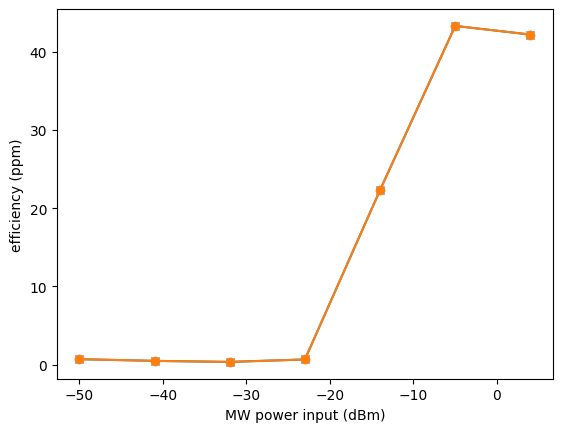

In [29]:
plt.plot(Pmu_vals_dBm, effic*1e6, 'x-',
         Pmu_vals_dBm, effic_approx*1e6, 'o-')
plt.ylabel('efficiency (ppm)')
plt.xlabel('MW power input (dBm)')

### Upconversion efficiency versus microwave power (for paper)

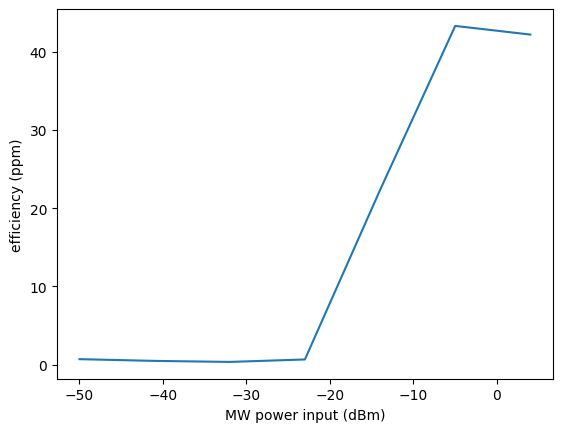

In [30]:
plt.plot(Pmu_vals_dBm, effic*1e6, '-')
plt.ylabel('efficiency (ppm)')
plt.xlabel('MW power input (dBm)')
saved_output['effic'] = effic

### Absorption at the frequency of the upconverted signal as a functionof microwave power (for paper)

In [31]:
# fix the delta_3 = 0 (on resonance with the signal frequency)
# but integrate over the inhomogeneous broadening of the microwave transition

df = 1e+6

m2 = p['mean_delta2']
sd2 = p['sd_delta2']

ndelta2 = 2*int(3*sd2/df)+1
delta2vals = np.linspace(-3, 3, ndelta2)*sd2+m2
pop = 0*delta2vals

# absorption at signal frequency
abs_vals = 0*Pmu_vals_dBm


for ii in range(len(Pmu_vals_dBm)):
    p['a'] = avals[ii]/alpha
    omegam_from_Pin(Pmu_vals_dBm[ii], p)
    for jj in range(len(delta2vals)):
        p['delta2'] = delta2vals[jj]
        rho = steady_rho_python(p)
        pop[jj] = rho[0, 0].real-rho[2, 2].real
        #print('%d %g %g'%(jj,delta2vals[jj],pop[jj]))
    abs_vals[ii] = integrate.simps(pop)


abs_vals = abs_vals/max(abs_vals)

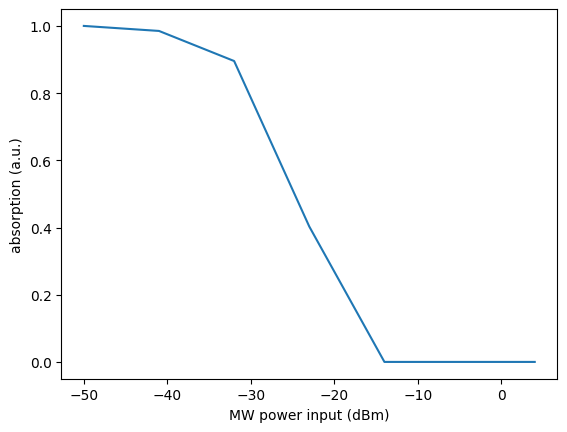

In [32]:
plt.plot(Pmu_vals_dBm, abs_vals, '-')
plt.ylabel('absorption (a.u.)')
plt.xlabel('MW power input (dBm)')

saved_output['abs_vals'] = abs_vals

## Looking at population distribution
### Higher power microwave driving

In [33]:
# set the microwave power to -20 dBm
omegam_from_Pin(-20, p)
saved_output['highpower'] = -20

p['a'] = 0
p['df'] = 5e6
steadya(p)
print(p['a'])
if patience == 0:
    p['df'] = 2e6
else:
    p['df'] = 0.5e6

steadya(p)
print(p['a'])

(-1.8365597668514235e-15+0.0005668410821535136j)
(3.798818574420584e-17+0.0006142879580067807j)


In [34]:
if patience == 2:
    npts = 301
elif patience == 1:
    npts = 101
elif patience == 0:
    npts = 101


delta_o_vals = np.linspace(-50e6, 50e6, npts)
delta_mu_vals = np.linspace(-30e6, 30e6, npts)

pop = np.zeros((len(delta_o_vals), len(delta_mu_vals), 3))

for ii in range(len(delta_o_vals)):
    for jj in range(len(delta_mu_vals)):
        p['delta2'] = delta_mu_vals[ii]
        p['delta3'] = delta_o_vals[jj]-delta_mu_vals[ii]
        rho = steady_rho_python(p)
        for kk in range(3):
            pop[ii, jj, kk] = rho[kk, kk].real

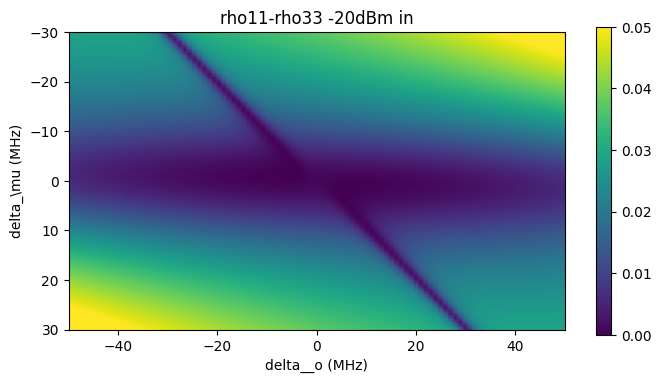

In [35]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.imshow(pop[:, :, 0]-pop[:, :, 2],
           extent=[min(delta_o_vals)/1e6,
                   max(delta_o_vals)/1e6,
                   max(delta_mu_vals)/1e6,
                   min(delta_mu_vals)/1e6],
           vmin=0, vmax=0.05)
plt.ylabel('delta_\mu (MHz)')
plt.xlabel('delta__o (MHz)')
plt.title('rho11-rho33 -20dBm in')
plt.colorbar()

saved_output['delta_o_vals'] = delta_o_vals
saved_output['delta_mu_vals'] = delta_mu_vals
saved_output['pop_diff_highpower'] = pop[:, :, 0]-pop[:, :, 2]

### lower microwave power

In [36]:
# set the microwave power to -50dBm
omegam_from_Pin(-50, p)
saved_output['lowpower'] = -50

p['a'] = 0
p['df'] = 5e6
steadya(p)
print(p['a'])
if patience == 0:
    p['df'] = 2e6
else:
    p['df'] = 0.5e6

steadya(p)
print(p['a'])

(-2.8725009009657585e-19+7.1463512913916014e-06j)
(1.0286277891678014e-19+9.44060579141193e-06j)


In [37]:
if patience == 2:
    npts = 301
elif patience == 1:
    npts = 101
elif patience == 0:
    npts = 101


delta_o_vals = np.linspace(-50e6, 50e6, npts)
delta_mu_vals = np.linspace(-30e6, 30e6, npts)

pop = np.zeros((len(delta_o_vals), len(delta_mu_vals), 3))

for ii in range(len(delta_o_vals)):
    for jj in range(len(delta_mu_vals)):
        p['delta2'] = delta_mu_vals[ii]
        p['delta3'] = delta_o_vals[jj]-delta_mu_vals[ii]
        rho = steady_rho_python(p)
        for kk in range(3):
            pop[ii, jj, kk] = rho[kk, kk].real

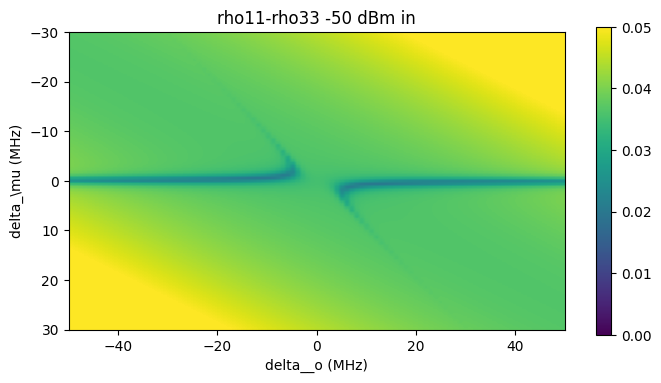

In [38]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.imshow(pop[:, :, 0]-pop[:, :, 2],
           extent=[min(delta_o_vals)/1e6, 
                   max(delta_o_vals)/1e6, 
                   max(delta_mu_vals)/1e6, 
                   min(delta_mu_vals)/1e6],
          vmin=0,vmax=0.05)


plt.ylabel('delta_\mu (MHz)')
plt.xlabel('delta__o (MHz)')
plt.title('rho11-rho33 -50 dBm in')
plt.colorbar();

saved_output['delta_o_vals']=delta_o_vals
saved_output['delta_mu_vals']=delta_mu_vals
saved_output['pop_diff_lowpower']=pop[:, :, 0]-pop[:, :, 2]

# Save output for later

In [39]:
filename = time.strftime("saved_output_%Y%m%d_%H%M%S.mat", time.gmtime())
sio.savemat(filename,saved_output)
filename

'saved_output_20231026_005633.mat'